### Classification

In [2]:
import pandas as pd
import numpy as np

### 1. Get output from clustering

In [377]:
df = pd.read_csv('../../output/outbreak_groups.csv')
df = df[['disease', 'country', 'year', 'month', 'peak_group']]
df = df.rename(columns={'peak_group': 'label'})
df['date'] = pd.to_datetime(df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + '1')
df['label_names'] = df.label.astype(str)
df.head()

,disease,country,year,month,label,date,label_names
0,Hantavirus,Austria,2008,1,0,2008-01-01,0
1,Hantavirus,Austria,2008,2,0,2008-02-01,0
2,Hantavirus,Austria,2008,3,0,2008-03-01,0
3,Hantavirus,Austria,2008,4,0,2008-04-01,0
4,Hantavirus,Austria,2008,5,0,2008-05-01,0


What is the distribution of the classes?

<Axes: xlabel='label_names', ylabel='Count'>

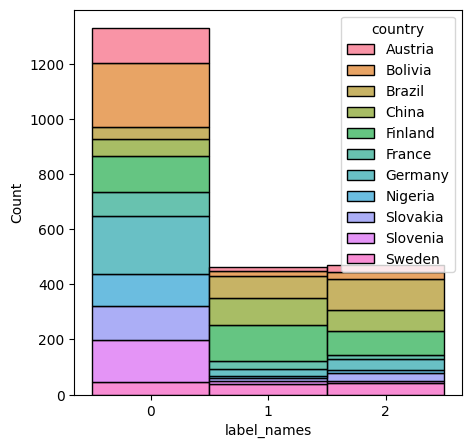

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
#df.set_index('label').plot(kind='bar', stacked=True) ## Plot
#plt.ticklabel_format(style='plain', useOffset=False, axis='y') ## No offset
#plt.gca().set_ylabel("Total $'s") ## Set Y-axis
#df.T.plot.bar(df.label, stacked=True, figsize=(12,6))
sns.histplot(data=df, x='label_names', hue='country', stat='count', multiple='stack')

### 2. Get climate data

In [274]:
climdf = pd.read_csv('../../data/processed/climate_data.csv')

,country,ADM0_CODE,adm1,ADM1_CODE,year,month,value,measure,unit
0,Finland,84,Aaland,16218.0,2000,2,-0.862194,mean_lst,celcius
1,Finland,84,Aaland,16218.0,2000,3,0.107945,mean_lst,celcius
2,Finland,84,Aaland,16218.0,2000,4,8.330545,mean_lst,celcius
3,Finland,84,Aaland,16218.0,2000,5,13.780449,mean_lst,celcius
4,Finland,84,Aaland,16218.0,2000,6,15.997800,mean_lst,celcius


In [289]:
# summary dataset
climdf = climdf.rename(columns={'ADM0_NAME': 'country'})
climdf = climdf.groupby(['country', 'month', 'year', 'measure']).mean('value').reset_index()
climdf['date'] = pd.to_datetime(climdf['year'].astype('str') + '-' + climdf['month'].astype('str') + '-' + '1')
#climdf = climdf.drop(['ADM0_CODE', 'ADM1_CODE'], axis=1)
#climdf = climdf.set_index('date')
climdf.head()

,country,month,year,measure,ADM0_CODE,ADM1_CODE,value,date
0,Austria,1,2008,EVI,18.0,NaN,1183.920226,2008-01-01
1,Austria,1,2008,mean_lst,18.0,NaN,-2.430510,2008-01-01
2,Austria,1,2008,precipitation,18.0,NaN,59.970422,2008-01-01
3,Austria,1,2009,EVI,18.0,NaN,831.511961,2009-01-01
4,Austria,1,2009,mean_lst,18.0,NaN,-6.638863,2009-01-01


### 3. Create training data array

In [387]:
# combine climate and case dataframes
#df = pd.merge(climdf, df)
df['id'] = df['country'] + '_' +df['disease'] + '_' + df['month'].astype(str) + '_' + df['year'].astype(str)
ids = np.array(df.id.unique())
#y = [d[1].label.unique()[0] for d in df.groupby(['id'])]
#y = np.array(y)

Create feature list for 3-month lag data

In [428]:
lag = 12
measures = ['mean_lst', 'precipitation', 'EVI']
num_measures = len(measures)
climlist = []
labels = []
ids = []
clim_dfs = []

for id, d in df.groupby(['id']):
    start_date = d.date.item() - pd.tseries.offsets.MonthBegin(lag+1)
    end_date = d.date.item()
    clim_select = climdf[climdf['measure'].isin(measures)]
    # select country
    clim_select = clim_select[(clim_select.country == d.country.item())]
    clim_select = clim_select[(clim_select.date > start_date) & (clim_select.date < end_date)]
    pivot_df = np.array(clim_select.pivot_table(index='month', columns='measure', values='value'))
    if pivot_df.shape == (lag, num_measures):
        if not np.isnan(pivot_df).any():
            clim_dfs.append(clim_select)
            climlist.append(pivot_df)
            labels.append(d.label.item())
            ids.append(d.id.item())

In [455]:
a = np.dstack(climlist)
X = a.T.reshape(len(climlist), num_measures, lag)
y = np.array(labels)

In [457]:
from sklearn.model_selection import train_test_split
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(940, 3, 12) (940,) (464, 3, 12) (464,)


In [458]:
from aeon.utils.validation import has_missing, is_equal_length, is_univariate
has_missing(X_test)
has_missing(X_train)

False

### 4. Train Classification Model

In [221]:
from sklearn import metrics

from aeon.classification.feature_based import Catch22Classifier, FreshPRINCEClassifier

from aeon.registry import all_estimators
from aeon.transformations.collection.feature_based import Catch22

In [459]:
from aeon.classification.convolution_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(X_train, y_train)
y_pred = rocket.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
metrics.balanced_accuracy_score(y_test, y_pred)

0.6247943722943723

In [466]:
c22cls = Catch22Classifier()
c22cls.fit(X_train, y_train)
c22_preds = c22cls.predict(X_test)
metrics.accuracy_score(y_test, c22_preds)

0.7413793103448276

In [460]:
fp = FreshPRINCEClassifier()
fp.fit(X_train, y_train)
fp_preds = fp.predict(X_test)
metrics.accuracy_score(y_test, fp_preds)

0.7413793103448276

In [465]:
metrics.balanced_accuracy_score(y_test, fp_preds)

0.6472510822510822

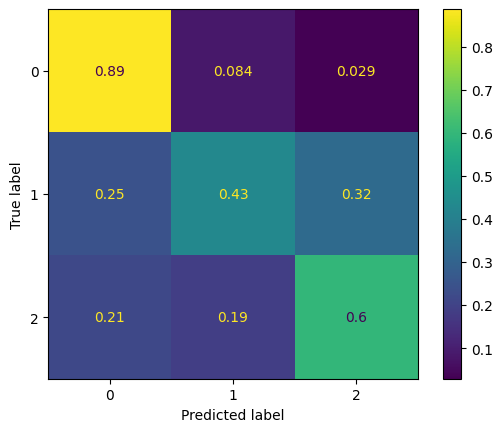

In [467]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(y_test, c22_preds, normalize='true')

plt.show()